# Week 02 – Glassbox Models (part 1)

In this notebook we'll be applying different glassbox models to the same dataset and compare their performance in terms of accuracy and f1-score and their interpretability.

#### Step 1: Navigate to this week's directory 
```
cd <path_to_week_2_material>
```

#### Step 2: Create and Activate a virtual environment (Python 3.9)
**MacOS**
```
python3.9 -m venv part1_venv
source part1_venv/bin/activate
```
To check whether your environment has the correct python version use
```
which python
```
It should show something like
```
../trustworthy_ai/02_glassbox/part1_venv/bin/python
```
**Windows (cmd)**
```
python3.9 -m venv part1_venv
part1_venv\Scripts\activate
```

#### Step 3: Install required packages
First, install `ipykernel` to integrate your virtual environment with Jupyter.
```
pip install ipykernel
python -m ipykernel install --user --name=part1_venv
```

Next, install all necessary dependencies from the requirements.txt file.
```
pip install -r requirements.txt
```

#### Step 4: Install `pydl8.5-lbguess`
```
git clone https://github.com/ubc-systopia/pydl8.5-lbguess.git
cd pydl8.5-lbguess
python3 setup.py install 
```
or if that does not work:
```
python setup.py install 
```
#### Step 5 (optional): Jupyter Notebook
To work with Jupyter Notebook, don't forget:
```
pip install jupyter
jupyter notebook
```
To exit, type ```ctrl+c``` and choose `y` in the terminal


**import packages**

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
import os
import sys
import matplotlib.pyplot as plt

# Load the dataset

We are using the [Titanic dataset](https://www.kaggle.com/c/titanic/overview), which holds data about passangers of the Titanic and whether they survived or not. Passengers are described by 7 features. The response variable is binary (0 – died; 1 - survived).

Make sure to save the dataset in the parent directory or adjust the file path below.

We are directly loading the pre-processed data sets. For some algorithms, we require the data to be in binary form. Hence, we have two versions of X: `X_train` and `X_test`, with continous features and one-hot encoded categorical features, and `X_train_bin` and `X_test_bin`, where all features have been one-hot encoded. For this, continuous features were first transformed into categories. Check the code in `./01_intro/titanic_data_prep.ipynb` for more details on pre-processing.

In [2]:
# X_train 
X_train = pd.read_csv('../datasets/titanic/encoded_titanic_X_train.csv')
X_train_bin = pd.read_csv('../datasets/titanic/bin_titanic_X_train.csv')

# X_test
X_test = pd.read_csv('../datasets/titanic/encoded_titanic_X_test.csv')
X_test_bin = pd.read_csv('../datasets/titanic/bin_titanic_X_test.csv')

# y_train and y_test
y_train = pd.read_csv('../datasets/titanic/titanic_y_train.csv')
y_test = pd.read_csv('../datasets/titanic/titanic_y_test.csv')

# take a look at the data
X_train.head()

,Age,SibSp,Parch,Fare,Sex_1,Embarked_1,Embarked_2,Pclass_1,Pclass_2
0,29.699118,0,0,7.6292,0,1,0,0,1
1,29.699118,0,0,8.0500,1,0,1,0,1
2,29.699118,0,0,7.7500,0,1,0,0,1
3,51.000000,1,0,77.9583,0,0,1,0,0
4,21.000000,0,0,7.7333,1,1,0,0,1


## About the dataset

- `Age` – age of a person in years (int)
- `SibSp` – the number of siblings or spouse of a person **onboard** (int)
- `Parch` – the number of parents or children of a person **onbard** (int)
- `Fare` – ticket price (float)
- `Sex` – sex of a person (categorical/binary)
- `Embarked` – location where the traveler mounted from. There are three possible values — Southampton, Cherbourg, and Queenstown (categorical)
- `Pclass` – passenger division into class 1, 2, and 3 (categorical)
- `Survived` – whether person survived the sinking of the ship (binary). Less than 40% survived. This is the **outcome** to predict. 


From the original dataset and from preprocessing the data, we know the following about the **categorical features**:

- `Sex` has two values `['female','male']`, which were encoded `[0,1]`, respectively. Then, after applying one-hot encoding, we have `Sex_1` which indicates `male` if 1, `female` otherwise.
- `Embarked` has three values `['C', 'Q', 'S']`, which were encoded `[0,1,2]`, respectively. Hence,
    - `Embarked_1 = 1` indicates `Q` 
    - `Embarked_2 = 1` indicates `S`
    - `Embarked_1 = 0` and `Embarked_2 = 0` indicated `C`
- `Pclass` has three values `[1,2,3]`, which were encoded `[0,1,2]`, respectively. Hence, after encoding, we have:
    - `Pclass_1 = 1` indicates `2`
    - `Pclass_2 = 1` indicates `3`
    - `Pclass_1 = 0` and `Pclass_2 = 0` indicates `1`

In [3]:
d = {
    'target': 'Survived',
    'numerical':['Age', 'SibSp', 'Parch', 'Fare'],
    'categorical':['Sex', 'Embarked', 'Pclass']
}

# save feature names
feature_names = X_train.columns
target_names = list(y_train[d['target']].unique())

# create a dataframe to save y values in 
y_results = pd.DataFrame()
y_results['y_test'] = y_test

---
---

# 1. Linear Models – Logistic Regression

The most commonly used package to run a logistic or linear regression model is `scikit-learn`. However, the package `interpret` has a wrapper for the logistic regression model fit by `scikit-learn`, with the added value of visualizing the model and for purposes of (global and local) interpretation. Hence, we will be using `interpret` to fit the logistic regression model.

In [4]:
# from sklearn.linear_model import LogisticRegression
from interpret.glassbox import LogisticRegression
from interpret import show

In [5]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_results['lr_pred'] = lr.predict(X_test)

## Inspect performance

In [6]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['lr_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['lr_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['lr_pred']))

Confusion matrix : 
 lr_pred   0   1
y_test         
0        99  11
1        25  44

Accuracy  = 0.7989
F1 score  = 0.7097


### Questions

**Q 1.1a – Evaluate the model performance using the confusion matrix and reported metrics.**

**Q 1.1b – Given that less that the survival rate is less tha 40%, is accuracy an appropriate primarty metric for this dataset? Name at least one risk of relying solely on accuracy.**

**Q 1.1c – Based on the confusion matrix, does the model show any systemic bias? Specifically, compare the model's performance on predicting deaths versus prediting survival. What might explain this difference?**

...

## Model interpretation
---
### GLOBAL

In [7]:
lr_global_expl = lr.explain_global()
show(lr_global_expl)

<!-- http://127.0.0.1:7001/6057386576/ -->

We can also inspect the feature contribution of each (or the x most important) feature(s) and/or interactions of features:

In [8]:
expl_dict = lr_global_expl.data()

# combine names and scores into tuples
name_score_pairs = list(zip(expl_dict['names'], expl_dict['scores']))

# sort by scores in descending order
sorted_name_score_pairs = sorted(name_score_pairs, key=lambda x: abs(x[1]), reverse=True)

# print the sorted names, scores, and ranks
for rank, (name, score) in enumerate(sorted_name_score_pairs, start=1):
    print(f'{rank}. {name}: {round(score,4)}')

1. Sex_1: -2.5858
2. Pclass_2: -1.9527
3. Pclass_1: -0.6859
4. SibSp: -0.3523
5. Embarked_2: -0.2363
6. Embarked_1: 0.0993
7. Parch: -0.0704
8. Age: -0.0377
9. Fare: 0.0043


### Questions

**Q 1.2 – Explain what is shown in the summary plot.**

...

---
### LOCAL

In [9]:
show(lr.explain_local(X_test, y_test))

<!-- http://127.0.0.1:7001/6076442272/ -->

### Questions

**Q 1.3 – Take a look at the local explanation for sample with index 2 of the test set. How do you explain that `Age` seems to be much more influential in the prediction for this instance, while it does receives almost no importance in the summary plot?**

...

---
---

# 2. Generalized Additive Models (GAM)

In [10]:
import scipy.stats as ss
from pygam import LogisticGAM, s, f, l, te

If you have a lot of features in the dataset, you may only want to pick some of the features to include in the model. For example, for each feature, we can check whether there is a significant correlation with the dependent variable. For categorical features, we use Chi-square; for numerical features we use Spearman's rank correlation. Then, we could select those where the associated p-value is below 0.05. However, here we will include all variables in the model.

Typically, we use factor terms `f()` for categorical variables and spline terms `s()` for numerical variables. We can use linear terms `l()` for numerical variables with a linear relationship to the response variable. Lastly, we could also incluse interaction terms `te()` between two features.

In [11]:
gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8))
gam.fit(X_train, y_train)

y_results['gam_pred'] = gam.predict(X_test)*1 # *1 to concert to 0's and 1's (from True and False)

## Inspect performance

In [12]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['gam_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['gam_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['gam_pred']))

Confusion matrix : 
 gam_pred   0   1
y_test          
0         95  15
1         22  47

Accuracy  = 0.7933
F1 score  = 0.7176


## Model interpretation
---
### GLOBAL

In [13]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     26.2537
Link Function:                        LogitLink Log Likelihood:                                   -289.182
Number of Samples:                          712 AIC:                                              630.8712
                                                AICc:                                             633.1236
                                                UBRE:                                               2.9156
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3899
Feature Function                  Lam

---
---
# 3. Explainable Boosting Machine (EBM)

Explainable Boosting Machine (EBM) has been implemented by interpretML. See the documentation here: https://interpret.ml/docs/python/api/ExplainableBoostingClassifier.html

In [14]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [15]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
y_results['ebm_pred'] = ebm.predict(X_test) #save predicted values

## Inspect performance

In [16]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['ebm_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['ebm_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['ebm_pred']))

Confusion matrix : 
 ebm_pred   0   1
y_test          
0         99  11
1         23  46

Accuracy  = 0.8101
F1 score  = 0.7302


### Questions

**Q 3.1 – Evaluate the performance of this model by taking into account the performance scores.**

...

## Model interpretation

---
### GLOBAL

In the display below, you can see the all feature importances in a summary plot and you can select each feature separately and inspect it's impact on the predictions more closely. 

In [17]:
ebm_global_expl = ebm.explain_global()
show(ebm_global_expl)

<!-- http://127.0.0.1:7001/6076812928/ -->

We can also inspect the feature contribution of each (or the x most important) feature(s) and/or interactions of features:

In [18]:
expl_dict = ebm_global_expl.data()

# combine names and scores into tuples
name_score_pairs = list(zip(expl_dict['names'], expl_dict['scores']))

# sort by scores in descending order
sorted_name_score_pairs = sorted(name_score_pairs, key=lambda x: x[1], reverse=True)

# print the sorted names, scores, and ranks
for rank, (name, score) in enumerate(sorted_name_score_pairs[:10], start=1):
    print(f'{rank}. {name}: {round(score,4)}')

1. Sex_1: 1.0466
2. Pclass_2: 0.4273
3. Fare: 0.3318
4. Age & Fare: 0.1913
5. SibSp: 0.1862
6. Age: 0.1836
7. Sex_1 & Pclass_2: 0.1742
8. Embarked_2: 0.1247
9. Fare & Sex_1: 0.1209
10. Sex_1 & Pclass_1: 0.1142


### Questions

**Q 3.2 – Explain how the feature importances in the summary plot are obtained.**

...

**Q 3.3 – How can we interpret the error bars in the plots of individual features?**

...

**Q 3.4 – Provide a full interpretation of the importance of feature `credit_amount` using these plots.**

...

---
### LOCAL

In [19]:
show(ebm.explain_local(X_test, y_test))

<!-- http://127.0.0.1:7001/6080241520/ -->

### Questions

**Q 3.5 – Take a look at the local explanation for sample with index 9 of the test set. How would you interpret this explanation?**

...

---
---
# 4. Decision Trees


## 4.1 Fast Sparse Decision Trees

This is a developing field and many people publish their code on Github. We will be using the code from this Github repo: https://github.com/ubc-systopia/pydl8.5-lbguess, which provides the code for the paper by [McTavish et al. (2022)](https://arxiv.org/abs/2112.00798) on Fast Sparse Decision Trees.

Note: This algorithm works with **binary** input data only. 

⚠️ This code requires `scikit-learn==1.1.2`.

In [20]:
sys.path.insert(1, os.path.dirname(os.getcwd())+'/pydl8.5-lbguess')
from dl85 import DL85Classifier
import fsdt_helpers 

ImportError: cannot import name 'DistanceMetric' from 'sklearn.neighbors' (/Users/adialumadjeng/Projects/trustworthy_ai/02_glassbox/part1_venv/lib/python3.9/site-packages/sklearn/neighbors/__init__.py)

In [ ]:
fsdt = DL85Classifier(time_limit=300, desc=True, max_depth=3)
fsdt.fit(X_train_bin, y_train)
y_results['fsdt_pred'] = fsdt.predict(X_test_bin) #save predicted values

TESTING STUFF
DL8.5 fitting: Solution found


## Inspect performance

In [ ]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['fsdt_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['fsdt_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['fsdt_pred']))

Confusion matrix : 
 fsdt_pred    0   1
y_test            
0          106   4
1           29  40

Accuracy  = 0.8156
F1 score  = 0.7080


### Questions

**Q 4.1.1 – Evaluate the performance of this model by taking into account the performance scores.**

...

## Model interpretation

We wrote some helper functions to extract the number of leaves (aka rules), the average rule length in the tree, and the average rule length per sample.

---
### GLOBAL

In [ ]:
print('Number of rules = %.0f' % fsdt_helpers.get_num_leaves(fsdt.tree_))
print('Average rule length = %.2f' % fsdt_helpers.get_avg_rule_length(fsdt.tree_))

Number of rules = 8
Average rule length = 3.00


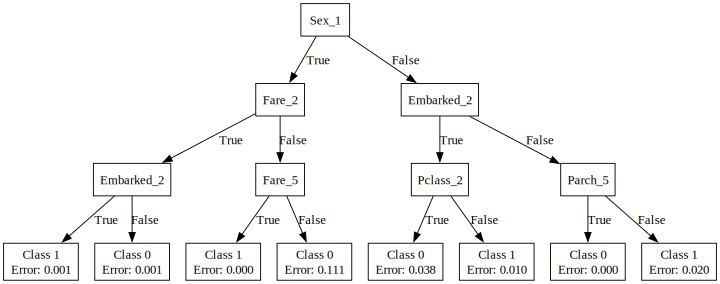

In [ ]:
# plot tree - had to install Graphviz system executables (dot) separately. With MacOS brew install graphviz, then check if installed using which dot
fsdt_helpers.display_tree(tree = fsdt.tree_, n = len(X_train_bin), feature_names = X_train_bin.columns)

### Questions

**Q 4.1.2 – Discuss global interpretability of the resulting tree.**

...

---
### LOCAL

In [ ]:
print('Average number of rules used per sample = %.2f' % 1.00)
print('Average rule length per sample = %.2f' % fsdt_helpers.get_avg_rule_length_per_sample(fsdt.tree_,np.array(X_test_bin)))

Average number of rules used per sample = 1.00
Average rule length per sample = 3.00


In [ ]:
X_test_bin.iloc[2,:]

Pclass_1      0
Pclass_2      1
Sex_1         0
Age_2         0
Age_3         1
Age_4         0
Age_5         0
SibSp_2       0
SibSp_3       0
SibSp_4       0
SibSp_5       0
Parch_2       0
Parch_3       0
Parch_4       0
Parch_5       1
Fare_2        0
Fare_3        0
Fare_4        0
Fare_5        0
Embarked_1    0
Embarked_2    1
Name: 2, dtype: int64

### Questions

**Q 4.1.3 – Explain how you would make the prediction for sample with index 2 of the test set.**

...

## 4.2 CART

Let's compare this to the most popular algorithm to grow a decision tree, which is called CART and is implemented in `scikit-learn`. 

To be able to **directly** compare both trees, we will again use the **binary** datasets `X_train_bin` and `X_test_bin` to train and test the model, respectively, even though CART can handle continous data.

Feel free to train CART on the continous data `X_train` and inspect the results as well.

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train_bin, y_train)
y_results['tree_pred'] = tree.predict(X_test_bin) #save predicted values

## Inspect performance

In [ ]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['tree_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['tree_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['tree_pred']))

Confusion matrix : 
 tree_pred    0   1
y_test            
0          107   3
1           36  33

Accuracy  = 0.7821
F1 score  = 0.6286


### Questions

**Q 4.2.1 – Evaluate the performance of this model by taking into account the performance scores.**

...

## Model interpretation 
---
### GLOBAL

Number of rules = 8
Average rule length = 3.00


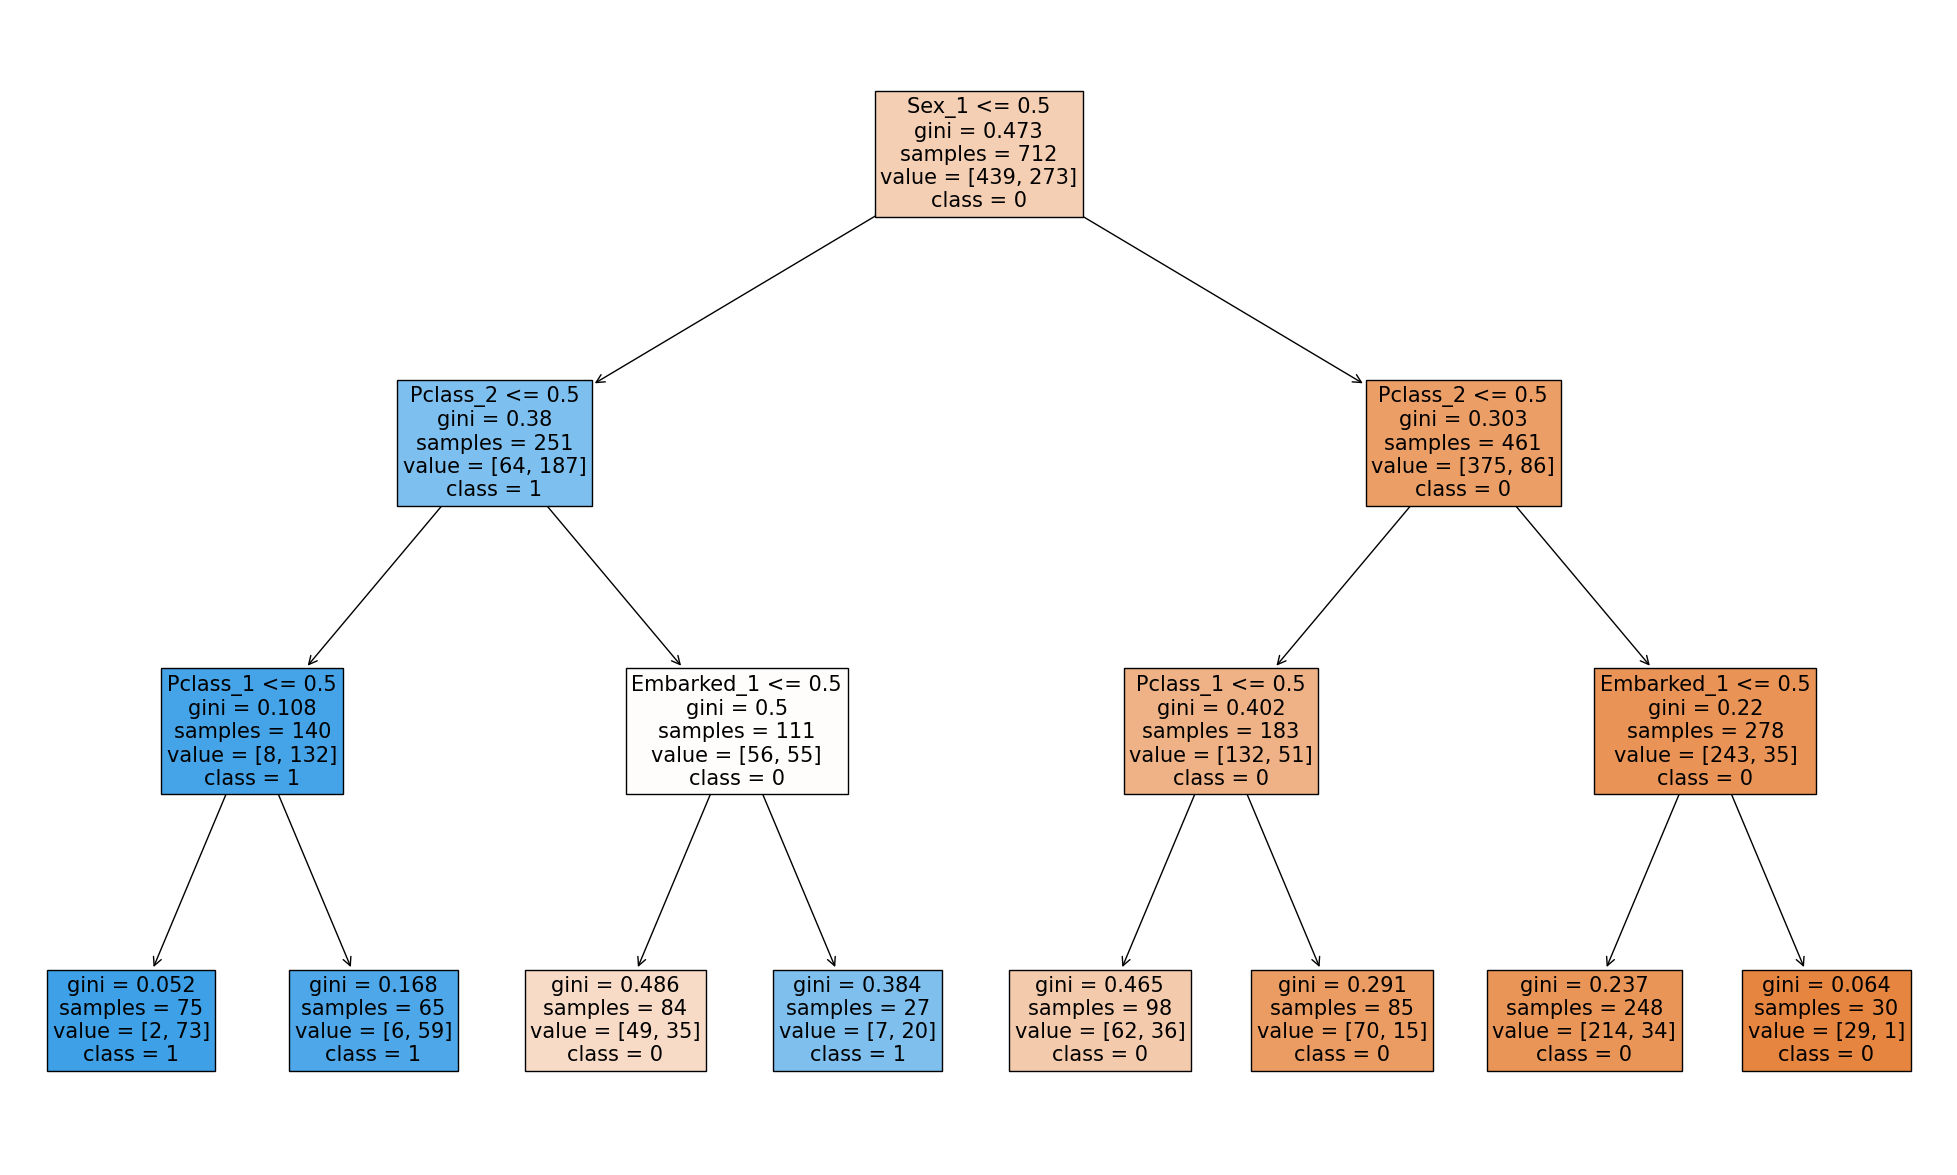

In [ ]:
fig = plt.figure(figsize=(25,15))
_ = plot_tree(tree, feature_names=X_train_bin.columns, class_names=['{:.0f}'.format(x) for x in target_names], filled=True, fontsize=15)

print('Number of rules = %.0f' % tree.get_n_leaves())
print('Average rule length = %.2f' % tree.get_depth())

### Questions

**Q 4.2.2 – Which feature is, based on this tree, the most important variable to predict survival?**

...

--- 
### LOCAL

### Questions

**Q 4.2.3 – Explain how you would make the prediction for sample with index 2 of the test set.**

...

---
---

# 5. Decision Rules

## 5.1 Decision Lists

We will use another algorithm that generates rules and is implemented in `interpret`. See the documentation here: https://interpret.ml/docs/dr.html. 

The package uses a wrapper for the algorithm skope-rules from [Gardin et al. (2017)](https://zenodo.org/records/4316671), which is a weighted combination of rules extracted from a tree ensemble using L1-regularized optimization over the weights.

Typically, in a decision list, the prediction is made using only the first rule in the list that applies to a sample.

In [ ]:
from interpret.glassbox import DecisionListClassifier

In [ ]:
dl = DecisionListClassifier(random_state=21, max_depth=3)
dl.fit(X_train, y_train)
y_results['dl_pred'] = dl.predict(X_test)

## Inspect performance

In [ ]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['dl_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['dl_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['dl_pred']))

Confusion matrix : 
 dl_pred   0   1
y_test         
0        95  15
1        21  48

Accuracy  = 0.7989
F1 score  = 0.7273


### Questions

**Q 5.1.1 – Evaluate the model performance.**

...

## Model interpretation
---
### GLOBAL

In [ ]:
dl_global_expl = dl.explain_global()
expl_dict = dl_global_expl.data()

In [ ]:
print('Number of rules = %.0f' % (len(dl.rules_)-1))
print('Average rule length = %.2f' % np.mean([r.count('and') for r in expl_dict['rule'][:-1]]))

Number of rules = 21
Average rule length = 2.00


In [ ]:
show(dl_global_expl)

<!-- http://127.0.0.1:7001/5507297680/ -->

### Questions

**Q 5.1.2 – Evaluate the global interpretability of the model.**

...

---
### LOCAL

In [ ]:
show(dl.explain_local(X_test, y_test))